# S&P 500

Goal: To predict S&P 500 stock closing price 15 days after my latest data point and 1 year after my latest data point.

[yfinance](https://algotrading101.com/learn/yfinance-guide/)

In [76]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
!pip install yfinance
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [77]:
SP500 = "^GSPC"
stock_data = yf.download(SP500)


/tmp/ipython-input-2879945641.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(SP500)
[*********************100%***********************]  1 of 1 completed


In [78]:

latest_date = stock_data.index[-1]  #gets latest date
start_date = latest_date - relativedelta(years=10)  #makes the start date 10yrs ago, just to get a overview of the data

stock_data = yf.download(SP500, start=start_date)

latest_date

/tmp/ipython-input-2737223293.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(SP500, start=start_date)
[*********************100%***********************]  1 of 1 completed


Timestamp('2025-12-12 00:00:00')

In [79]:
stock_data.tail()  #double check latest data points (specifically what date is the last data point on)

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2025-12-08,6846.509766,6878.270020,6827.189941,6875.200195,4757130000
2025-12-09,6840.509766,6864.919922,6837.430176,6840.609863,4508050000
2025-12-10,6886.680176,6900.669922,6824.689941,6833.490234,5526570000
2025-12-11,6901.000000,6903.459961,6833.450195,6861.299805,5021060000
2025-12-12,6827.410156,6899.850098,6801.790039,6886.850098,3163284000


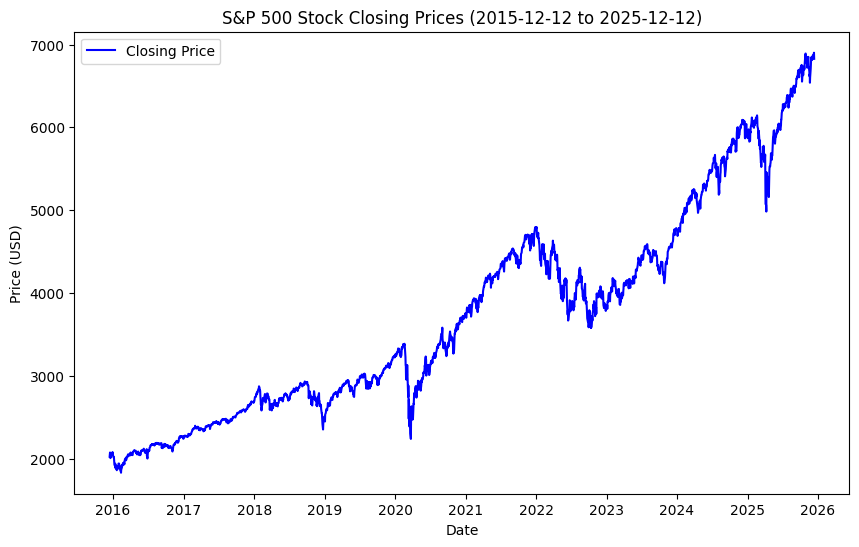

In [80]:
plt.figure(figsize=(10, 6)); plt.plot(stock_data['Close'], label='Closing Price', color='blue'); plt.title(f"S&P 500 Stock Closing Prices ({start_date.strftime('%Y-%m-%d')} to {latest_date.strftime('%Y-%m-%d')})"); plt.xlabel("Date"); plt.ylabel("Price (USD)"); plt.legend();

#  Linear Model (for predicting closing price 15 days later) using only the variables closing price vs days

In [81]:
linear_startdate = latest_date - relativedelta(months=6)    #makes the start date 6 months before latest data point
stock_data = yf.download(SP500, start=linear_startdate)

linear_startdate

/tmp/ipython-input-568935789.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(SP500, start=linear_startdate)
[*********************100%***********************]  1 of 1 completed


Timestamp('2025-06-12 00:00:00')

Since I want to predict the price only 15 days later, which is only a couple days after my last data point, using less data (6 months) would be better for a linear model since when looking at data from longer periods of time stock price increases expoentially, so a linear model over such a large time frame would not work so well. A polynomial model for predicting only 15 days in advance would introduce too much complexity.

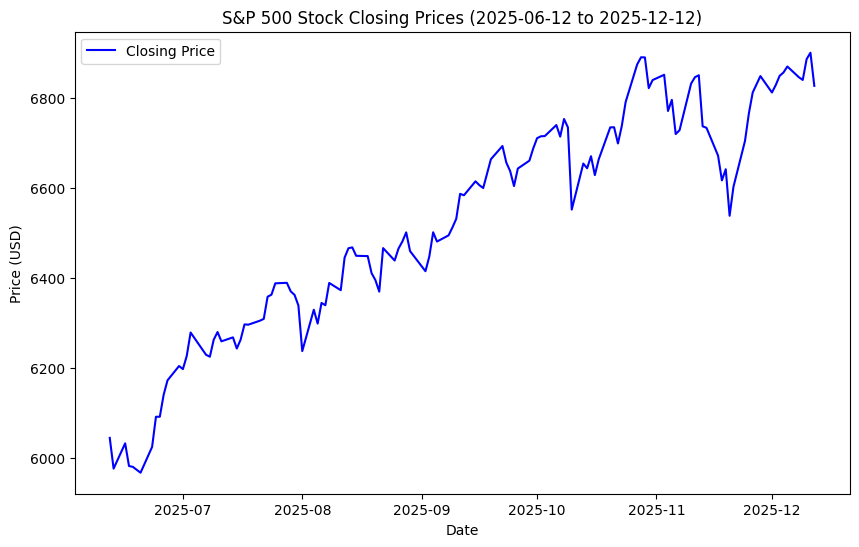

In [82]:
plt.figure(figsize=(10, 6)); plt.plot(stock_data['Close'], label='Closing Price', color='blue'); plt.title(f"S&P 500 Stock Closing Prices ({linear_startdate.strftime('%Y-%m-%d')} to {latest_date.strftime('%Y-%m-%d')})"); plt.xlabel("Date"); plt.ylabel("Price (USD)"); plt.legend();

In [83]:
stock_data['Days'] = (stock_data.index - stock_data.index[0]).days   #changes the date time data to days since the start_date so they would be int/floats

In [84]:
#fit model
X = stock_data[['Days']]
y = stock_data['Close']

lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)

In [85]:
slope = float(lr.coef_[0])
intercept = float(lr.intercept_)
print(slope)
print(intercept)

4.407378042892783
6119.209781899079


/tmp/ipython-input-452852561.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  slope = float(lr.coef_[0])
/tmp/ipython-input-452852561.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercept = float(lr.intercept_)


### Results

In [86]:
print(f"Linear equation: y = {slope:.2f}x + {intercept:.2f}")

Linear equation: y = 4.41x + 6119.21


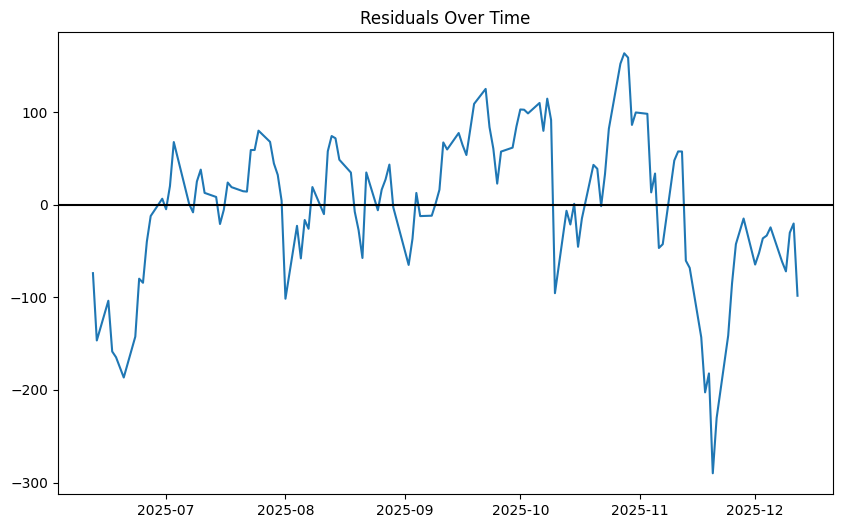

In [87]:
#plot residuals
resids = (y - y_pred)

fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(resids, '-'); ax.axhline(color = 'black'); ax.set_title('Residuals Over Time');

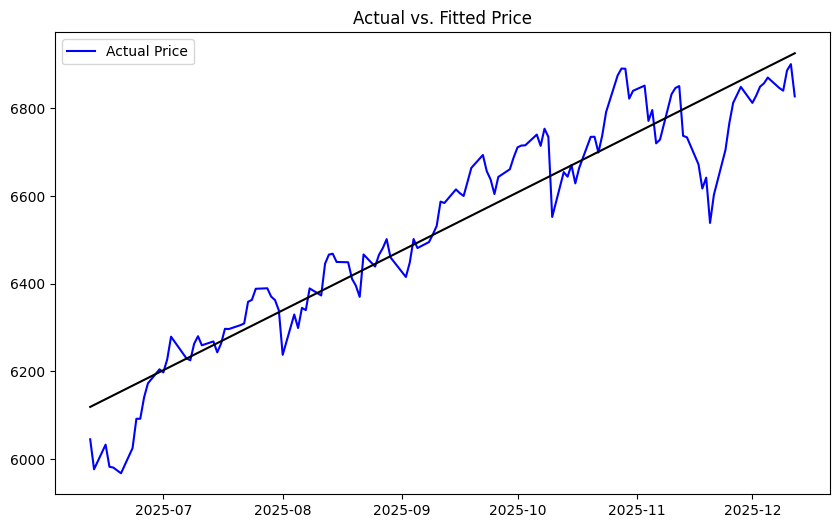

In [88]:

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(stock_data.index, y, label='Actual Price', color='blue'); ax.plot(stock_data.index, lr.predict(X), color = 'black'); ax.set_title('Actual vs. Fitted Price'); ax.legend();

In [89]:
#seeing how strong the model is
r_squared = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
print(f"Linear Model Performance (most recent 6 months)")
print(f"R-squared (R²): {r_squared:.4f}")
print(f"Mean Squared Error (MSE): {mse:,.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f}")

Linear Model Performance (most recent 6 months)
R-squared (R²): 0.8935
Mean Squared Error (MSE): 6,469.20
Root Mean Squared Error (RMSE): 80.43


### Prediction

In [90]:
target_date = latest_date + timedelta(days=15)
target_date

Timestamp('2025-12-27 00:00:00')

In [91]:
days_for_prediction = (target_date - stock_data.index[0]).days

X_pred = np.array([[days_for_prediction]])
linear_predicted_price = lr.predict(X_pred)

#gets latest actual closing price and predicted price
last_closing_price = stock_data['Close'].iloc[-1].item()
pred_closing_price = linear_predicted_price[0].item()

print(f"Latest Actual Closing Price on {stock_data.index[-1].strftime('%Y-%m-%d')}: ${last_closing_price:,.2f}");
print(f"Predicted Closing Price on {target_date.strftime('%Y-%m-%d')}: ${pred_closing_price:,.2f}")

Latest Actual Closing Price on 2025-12-12: $6,827.41
Predicted Closing Price on 2025-12-27: $6,991.87


**Looking at the Root Mean Squared Error, we can see on average, the linear model is only off by $81.37 from the actual S&P 500 closing price over the last 6 months. As we can see, for a short time frame, a linear model could possibly be better when predicting prices only a couple days away.**

# Polynomial Model (for predicting stock price 1 yr later)

For this since we are predicting the stock price 1 yr later, a polynomial model would be better to take into account the expoential growth. Therefore we will use the data from the past 15 years.

In [92]:
poly_startdate = latest_date - relativedelta(years=15)   #makes start date 15 yrs ago
stock_data = yf.download(SP500, poly_startdate)


/tmp/ipython-input-2869834080.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(SP500, poly_startdate)
[*********************100%***********************]  1 of 1 completed


In [93]:
earliest_date = stock_data.index[0].strftime('%Y-%m-%d')
earliest_date

'2010-12-13'

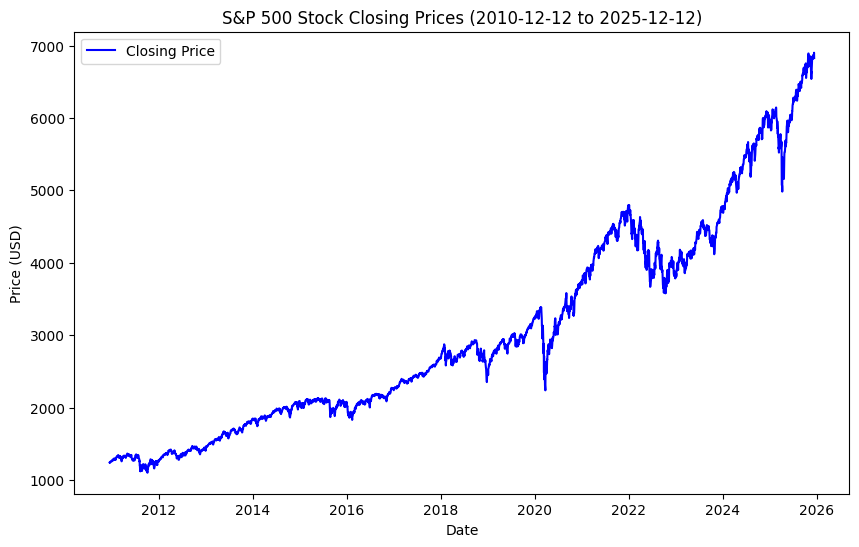

In [94]:
plt.figure(figsize=(10, 6)); plt.plot(stock_data['Close'], label='Closing Price', color='blue'); plt.title(f"S&P 500 Stock Closing Prices ({poly_startdate.strftime('%Y-%m-%d')} to {latest_date.strftime('%Y-%m-%d')})"); plt.xlabel("Date"); plt.ylabel("Price (USD)"); plt.legend();

In [95]:
stock_data['Days'] = (stock_data.index - stock_data.index[0]).days  #update the days feature with the new start date

### Will use Train Test Split to see how well our model does on unseen data.

In [96]:
split_date = latest_date - relativedelta(years=3)  #makes the split date 3 yrs ago
split_date

Timestamp('2022-12-12 00:00:00')

In [97]:
#cannot set train test split randomly because data is a timeseries  (if random, will be training on data from the future(same time period as testing data) will make it over confident -> no good)
#need to manually split it
X_train = stock_data.loc[stock_data.index < split_date, 'Days'].values.reshape(-1, 1)  #.reshape(-1,1) changes shape of NumPy array from 1D to 2D
y_train = stock_data.loc[stock_data.index < split_date, 'Close'].values    #.values make it a NumPy array
X_test = stock_data.loc[stock_data.index >= split_date, 'Days'].values.reshape(-1, 1)
y_test = stock_data.loc[stock_data.index >= split_date, 'Close'].values

In [98]:
poly_features = PolynomialFeatures(degree=4)

originally used degrees = 2; found it did poorer on the testing data compared to degree = 4; also degree 2 doesn't really account for the recent changes as much, since a 1 yr forcast isn't really that much later in the future, recent changes are important. Degree = 4 performed better compared to other degrees (2,3,5,..)


In [99]:
X_train_poly = poly_features.fit_transform(X_train)  # Fit and transform training data
#fit model
poly_lr = LinearRegression()
poly_lr.fit(X_train_poly, y_train)

X_test_poly = poly_features.transform(X_test)
test_preds = poly_lr.predict(X_test_poly)

In [100]:
#seeing how strong the model is
r_squared_test = r2_score(y_test, test_preds)
mse_test = mean_squared_error(y_test, test_preds)
rmse_test = np.sqrt(mse_test)

print("Polynomial Model Performance (on Unseen Testing Data: the past 3 yrs)")
print("---------------------------------------------------------------")
print(f"R-squared (R²): {r_squared_test:.4f}")
print(f"Mean Squared Error (MSE): {mse_test:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse_test:,.2f} USD")

Polynomial Model Performance (on Unseen Testing Data: the past 3 yrs)
---------------------------------------------------------------
R-squared (R²): 0.7840
Mean Squared Error (MSE): 163,634.38
Root Mean Squared Error (RMSE): $404.52 USD


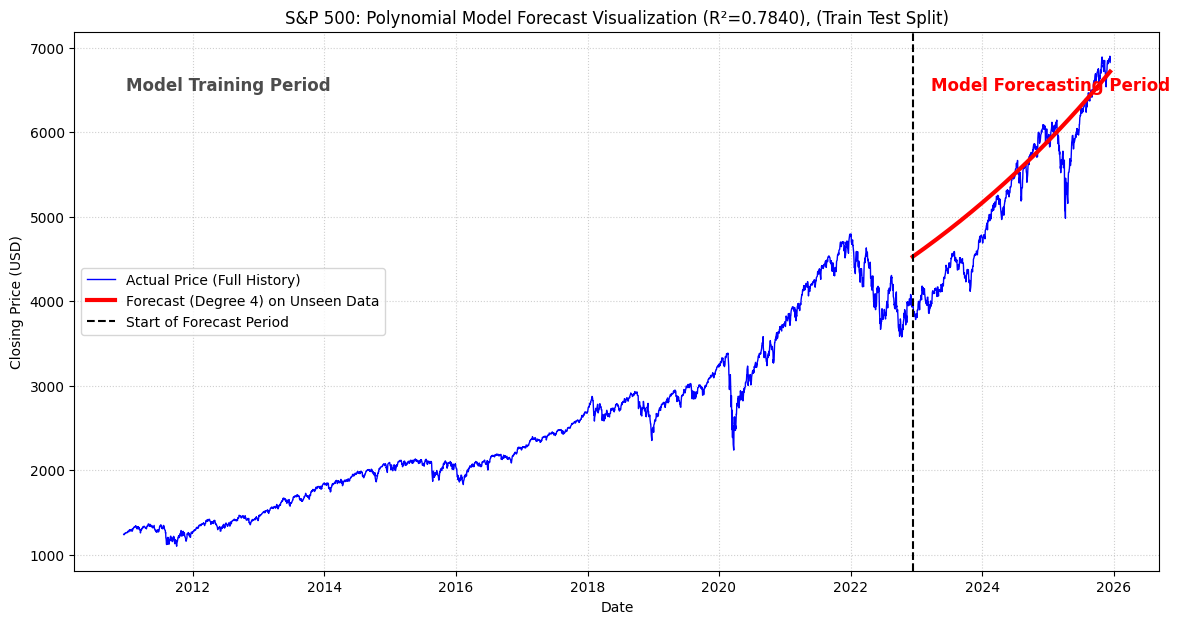

In [101]:
y_test_index = stock_data.loc[stock_data.index >= split_date].index
fig, ax = plt.subplots(figsize=(14, 7))
#plot
ax.plot(stock_data.index, stock_data['Close'], label='Actual Price (Full History)', color='blue', linewidth=1); ax.plot(y_test_index, test_preds, label=f'Forecast (Degree 4) on Unseen Data', color='red', linewidth=3, linestyle='-')
#Labels
ax.axvline(split_date, color='black', linestyle='--', linewidth=1.5, label='Start of Forecast Period')
ax.text(stock_data.index[10], 6500, 'Model Training Period', color='black', fontsize=12, weight='bold', alpha=0.7); ax.text(split_date + pd.Timedelta(days=100), 6500, 'Model Forecasting Period', color='red', fontsize=12, weight='bold')
ax.set_title(f'S&P 500: Polynomial Model Forecast Visualization (R²={r_squared_test:.4f}), (Train Test Split)'); ax.set_xlabel('Date'); ax.set_ylabel('Closing Price (USD)'); ax.legend(); plt.grid(True, linestyle=':', alpha=0.6)


Will now train our model on the full past 15 yrs, including the most recent data (the past 3 yrs)

In [102]:
X_all = stock_data[['Days']].values.reshape(-1, 1)
y_all = stock_data['Close'].values

In [103]:
X_all_poly = poly_features.fit_transform(X_all) # Fit and transform on ALL data

#Retrain Final Model
poly_lr_final = LinearRegression()
poly_lr_final.fit(X_all_poly, y_all)

LinearRegression()

In [104]:
# X_all_poly and y_all contain the full 15 years of data.
X_all_poly = poly_features.transform(X_all)
y_pred_final = poly_lr_final.predict(X_all_poly)

#Performance Metrics (Fit on ALL 15 years of historical data)
r_squared_full = r2_score(y_all, y_pred_final)
mse_full = mean_squared_error(y_all, y_pred_final)
rmse_full = np.sqrt(mse_full)

print("Final Polynomial Model Performance (on ALL 15 Years)")
print("------------------------------------------------------------------")
print(f"R-squared (R²): {r_squared_full:.4f}")
print(f"Mean Squared Error (MSE): {mse_full:,.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_full:,.2f}")

Final Polynomial Model Performance (on ALL 15 Years)
------------------------------------------------------------------
R-squared (R²): 0.9682
Mean Squared Error (MSE): 66,839.05
Root Mean Squared Error (RMSE): 258.53


### Prediction

In [105]:
poly_targetdate = latest_date + relativedelta(years=1)   #predict 1 year later

# Days count from the start of the 15-year dataset to the target date
days_for_prediction = (poly_targetdate - stock_data.index[0]).days

X_pred_raw = np.array([[days_for_prediction]])
X_pred_poly = poly_features.transform(X_pred_raw)

poly_predicted_price = poly_lr_final.predict(X_pred_poly)
final_pred_closing_price = poly_predicted_price[0].item()

In [106]:
print("1-Year Polynomial Forecast")
print(f"Prediction Date: {poly_targetdate.strftime('%Y-%m-%d')}")
print(f"Predicted Closing Price: ${final_pred_closing_price:,.2f}")

1-Year Polynomial Forecast
Prediction Date: 2026-12-12
Predicted Closing Price: $7,840.83


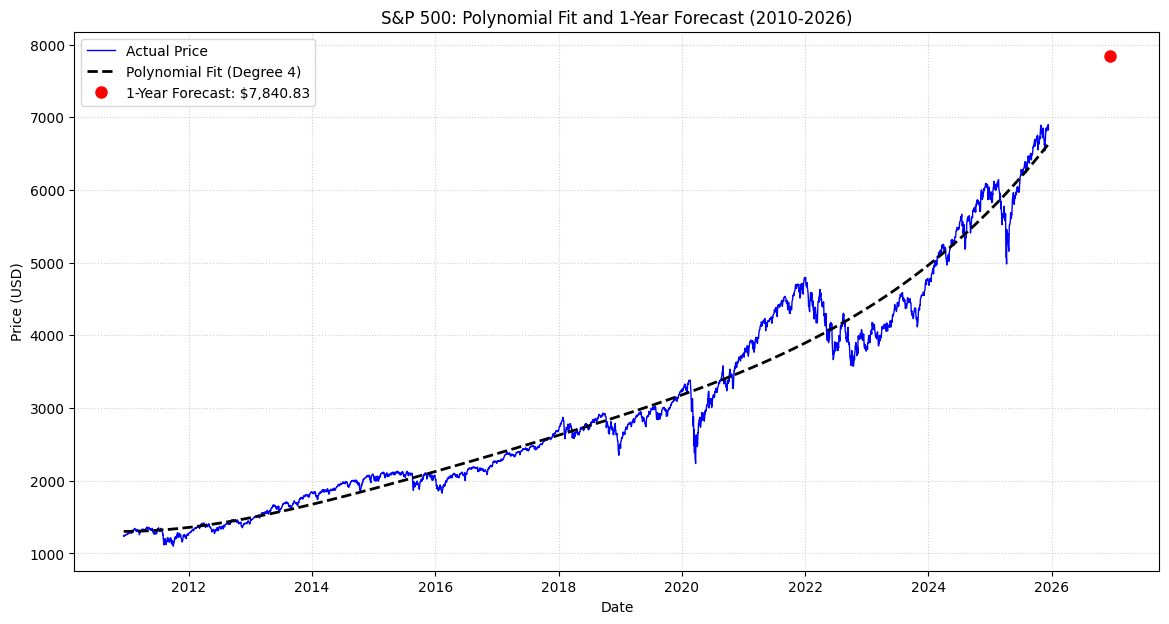

In [107]:
fig, ax = plt.subplots(figsize=(14, 7))

# Plot
ax.plot(stock_data.index, y_all, label='Actual Price', color='blue', linewidth=1)
ax.plot(stock_data.index, y_pred_final, label=f'Polynomial Fit (Degree 4)', color='black', linewidth=2, linestyle='--')
ax.plot(pd.to_datetime(poly_targetdate), final_pred_closing_price, 'ro', markersize=8, label=f'1-Year Forecast: ${final_pred_closing_price:,.2f}') # 'ro' means red circle

ax.set_title(f'S&P 500: Polynomial Fit and 1-Year Forecast ({stock_data.index[0].year}-{poly_targetdate.year})'); ax.set_xlabel('Date'); ax.set_ylabel('Price (USD)'); ax.legend(); plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

# Sequential Model: forcasting 15 days later

using multiple predictors (Open, High, Low, Days, Average Percent Change, Moving Average Convergence Divergence)

In [108]:
latest_date

Timestamp('2025-12-12 00:00:00')

In [109]:
data = stock_data.copy()
data['Days'] = (data.index - stock_data.index[0]).days
LAG_WINDOW = 5

#5-Day Average Percentage Change
data['Pct_Change_5D_Avg'] = data['Close'].pct_change().rolling(window=5).mean() * 100

#Moving Average Crossover (Short MA - Long MA)
data['MA_Short'] = data['Close'].rolling(window=10).mean()
data['MA_Long'] = data['Close'].rolling(window=50).mean()
data['MAC_Signal'] = data['MA_Short'] - data['MA_Long']

data['Close_Target'] = data['Close'].shift(-15)

for i in range(1, LAG_WINDOW + 1):
  data[f'Close_Lag_{i}'] = data['Close'].shift(i)

X_features = ['Days', 'Open', 'High', 'Low', 'Pct_Change_5D_Avg', 'MAC_Signal'] + [f'Close_Lag_{i}' for i in range(1, LAG_WINDOW + 1)]

data = data.dropna()
X = data[X_features].values
y = data['Close_Target'].values

direct_lagged_lr = LinearRegression()
direct_lagged_lr.fit(X, y)

#Stats
y_pred_direct_lagged = direct_lagged_lr.predict(X)
r_squared_direct_lagged = r2_score(y, y_pred_direct_lagged)
rmse_direct_lagged = np.sqrt(mean_squared_error(y, y_pred_direct_lagged))
mes_sequential = mean_squared_error(y, y_pred_direct_lagged)

#15-Day Direct Prediction
latest_data_row = stock_data.iloc[-1]
latest_date = stock_data.index[-1]
target_date = latest_date + timedelta(days=21)
days_offset = (latest_date - stock_data.index[0]).days

days_for_prediction = float(days_offset + 15)
open_today = float(latest_data_row['Open'].item())
high_today = float(latest_data_row['High'].item())
low_today = float(latest_data_row['Low'].item())
close_today = float(latest_data_row['Close'].item())

close_history = stock_data['Close']

#current 5-Day Avg % Change
if len(close_history) >= 5:
    pct_change_5d_avg_current = close_history.pct_change().rolling(window=5).mean().iloc[-1].item() * 100
    pct_change_5d_avg_current = float(pct_change_5d_avg_current)
else:
    pct_change_5d_avg_current = 0.0

#current MAC_Signal
if len(close_history) >= 50:
    ma_short_current = close_history.rolling(window=10).mean().iloc[-1]
    ma_long_current = close_history.rolling(window=50).mean().iloc[-1]
    mac_signal_current = float(ma_short_current.item() - ma_long_current.item())
else:
    mac_signal_current = 0.0

pred_lags_array = data.iloc[-1][[f'Close_Lag_{i}' for i in range(1, LAG_WINDOW + 1)]].values
pred_lags_list = [float(x) for x in pred_lags_array]

X_pred_features = [days_for_prediction, open_today, high_today, low_today, pct_change_5d_avg_current, mac_signal_current] + pred_lags_list

X_pred = np.array([X_pred_features])

predicted_price_15d = direct_lagged_lr.predict(X_pred)[0].item()

print("Sequential Model (multiple variables)")
print("----------------------------------------------------------------------")
print(f"R-squared (R²): {r_squared_direct_lagged:.4f}")
print(f"Mean Squared Eror (MSE): {mes_sequential:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse_direct_lagged:,.2f} USD")

print("Predictions:")

print(f"Latest Actual Closing Price ({latest_date.strftime('%Y-%m-%d')}): ${close_today:,.2f}")
print(f"Final 15-Day Forecast Price ({target_date.strftime('%Y-%m-%d')}): ${predicted_price_15d:,.2f}")

Sequential Model (multiple variables)
----------------------------------------------------------------------
R-squared (R²): 0.9927
Mean Squared Eror (MSE): 15,195.17
Root Mean Squared Error (RMSE): $123.27 USD
Predictions:
Latest Actual Closing Price (2025-12-12): $6,827.41
Final 15-Day Forecast Price (2026-01-02): $6,883.60


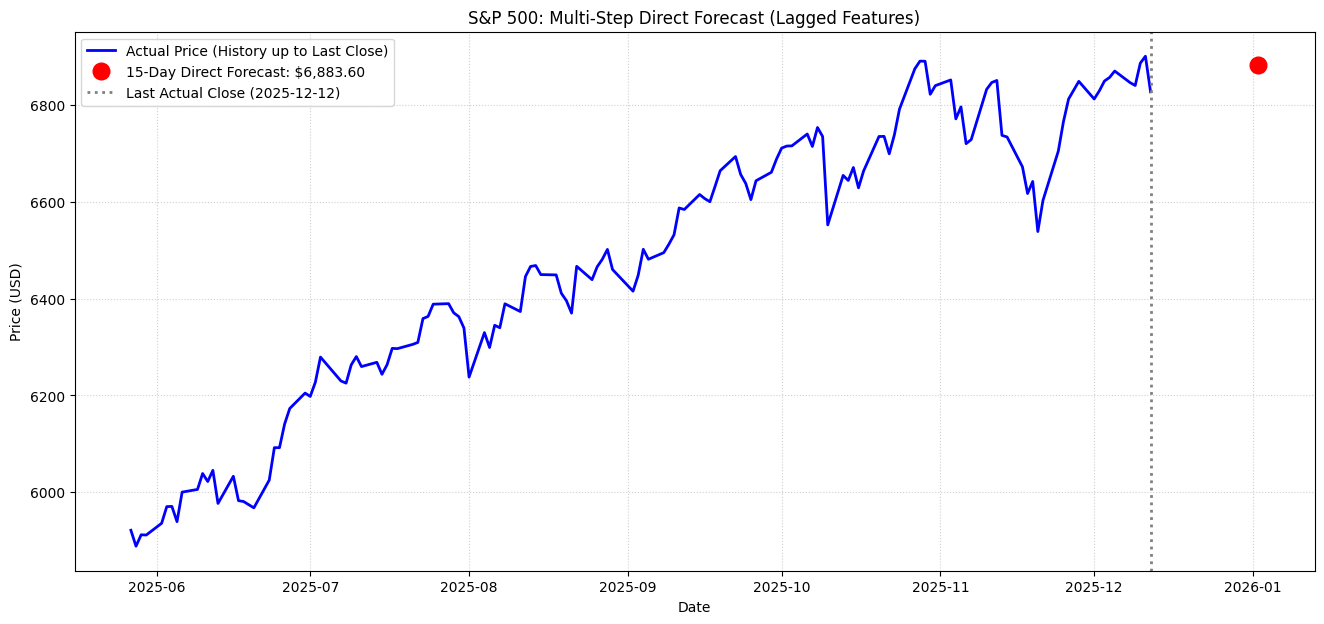

In [110]:
# Plot Range
plot_start_date = latest_date - pd.Timedelta(days = 200)
historical_data = stock_data[stock_data.index >= plot_start_date].copy()

fig, ax = plt.subplots(figsize=(16, 7))
ax.plot(historical_data.index, historical_data['Close'], label='Actual Price (History up to Last Close)', color='blue', linewidth=2); ax.plot(target_date, predicted_price_15d, 'ro', markersize=12, label=f'15-Day Direct Forecast: ${predicted_price_15d:,.2f}')
#label
ax.axvline(latest_date, color='grey', linestyle=':', linewidth=2, label=f'Last Actual Close ({latest_date.strftime("%Y-%m-%d")})'); ax.set_title('S&P 500: Multi-Step Direct Forecast (Lagged Features)'); ax.set_xlabel('Date'); ax.set_ylabel('Price (USD)'); ax.legend(); plt.grid(True, linestyle=':', alpha=0.6)

### Train Test Split

In [111]:
split_index = int(0.80 * len(X))

X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

direct_lagged_lr = LinearRegression()
direct_lagged_lr.fit(X_train, y_train)

y_test_pred = direct_lagged_lr.predict(X_test)

r_squared_test = r2_score(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)

print("Sequential Model Performance Metrics (Train/Test Split)")
print("-----------------------------------------------------")
print(f"R-squared (R²): {r_squared_test:.4f}")
print(f"Mean Squared Error (MSE): {mse:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f} USD")


Sequential Model Performance Metrics (Train/Test Split)
-----------------------------------------------------
R-squared (R²): 0.9465
Mean Squared Error (MSE): 39,523.01
Root Mean Squared Error (RMSE): $198.80 USD


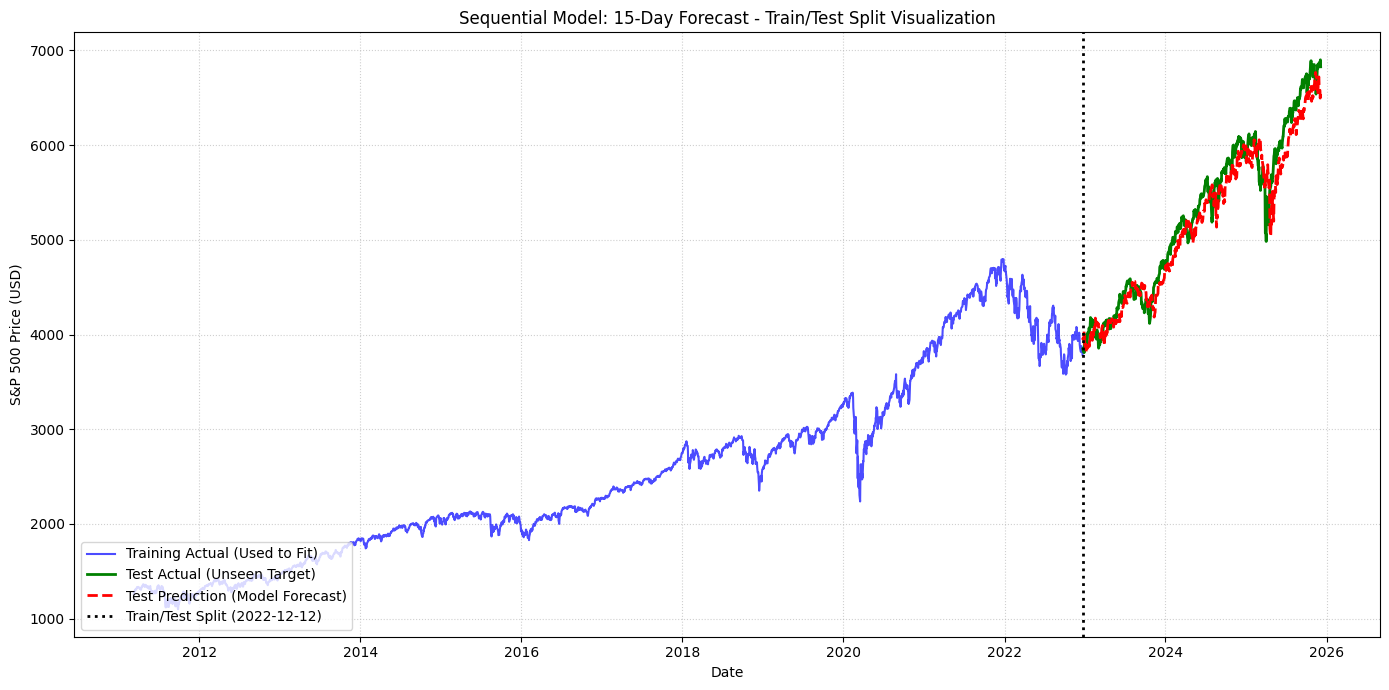

In [112]:
dates_train = data.index[:split_index]
dates_test = data.index[split_index:]

dates_train_shifted = dates_train + timedelta(days=15)
dates_test_shifted = dates_test + timedelta(days=15)

fig, ax = plt.subplots(figsize=(14, 7))
#plot
ax.plot(dates_train_shifted, y_train, label='Training Actual (Used to Fit)', color='blue', linewidth=1.5, alpha=0.7)
ax.plot(dates_test_shifted, y_test, label='Test Actual (Unseen Target)', color='green', linewidth=2)
ax.plot(dates_test_shifted, y_test_pred, label='Test Prediction (Model Forecast)', color='red', linestyle='--', linewidth=2)
#labels
ax.axvline(dates_test_shifted[0] if len(dates_test_shifted) > 0 else data.index[-1], color='black', linestyle=':', linewidth=2, label=f'Train/Test Split ({split_date.strftime("%Y-%m-%d")})')
ax.set_title('Sequential Model: 15-Day Forecast - Train/Test Split Visualization'); ax.set_xlabel('Date'); ax.set_ylabel('S&P 500 Price (USD)'); ax.legend(loc='lower left'); plt.grid(True, linestyle=':', alpha=0.6); plt.tight_layout(); plt.savefig('train_test_split_visualization.png')
